In [1]:
%matplotlib inline


# Speed up computations with parallel_compute()

**Suhas Somnath, Chris R. Smith**

9/8/2017

**This document will demonstrate how ``sidpy.proc.comp_utils.parallel_compute()`` can significantly speed up data processing by
using all available CPU cores in a computer**


## Introduction
Quite often, we need to perform the same operation on every single component in our data. One of the most popular
examples is functional fitting applied to spectra collected at each location on a grid. While, the operation itself
may not take very long, computing this operation thousands of times, once per location, using a single CPU core can
take a long time to complete. Most personal computers today come with at least two cores, and in many cases, each of
these cores is represented via two logical cores, thereby summing to a total of at least four cores. Thus, it is
prudent to make use of these unused cores whenever possible. Fortunately, there are a few python packages that
facilitate the efficient use of all CPU cores with minimal modifications to the existing code.

``sidpy.proc.comp_utils.parallel_compute()`` is a very handy function that simplifies parallel computation significantly to a
**single function call** and will be discussed in this document.

## Example scientific problem
For this example, we will be working with a ``Band Excitation Piezoresponse Force Microscopy (BE-PFM)`` imaging dataset
acquired from advanced atomic force microscopes. In this dataset, a spectra was collected for each position in a two
dimensional grid of spatial locations. Thus, this is a three dimensional dataset that has been flattened to a two
dimensional matrix in accordance with **Universal Spectroscopy and Imaging Data (USID)** model.

Each spectra in this dataset is expected to have a single peak. The goal is to find the positions of the peaks in each
spectra. Clearly, the operation of finding the peak in one spectra is independent of the same operation on another
spectra. Thus, we could in theory divide the dataset in to N parts and use N CPU cores to compute the results much
faster than it would take a single core to compute the results. There is an important caveat to this statement and it
will be discussed at the end of this document.

**Here, we will learn how to fit the thousands of spectra using all available cores on a computer.**
Note, that this is applicable only for a single CPU. Please refer to another advanced example for multi-CPU computing.

<div class="alert alert-info"><h4>Note</h4><p>In order to run this document on your own computer, you will need to:

    1. Download the document as a Jupyter notebook using the link at the bottom of this page.
    2. Save the contents of `this python file <https://github.com/pycroscopy/sidpy/blob/master/examples/proc/supporting_docs/peak_finding.py>`_ as ``peak_finding.py`` in the
       same folder as the notebook from step 1.</p></div>

Ensure python 3 compatibility:



In [2]:
from __future__ import division, print_function, absolute_import, unicode_literals

# The package for accessing files in directories, etc.:
import os

# Warning package in case something goes wrong
from warnings import warn
import subprocess


def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])
# Package for downloading online files:
try:
    # This package is not part of anaconda and may need to be installed.
    import wget
except ImportError:
    warn('wget not found.  Will install with pip.')
    import pip
    install(wget)
    import wget

# The mathematical computation package:
import numpy as np

# The package used for creating and manipulating HDF5 files:
import h5py

# Packages for plotting:
import matplotlib.pyplot as plt

# Parallel computation library:
try:
    import joblib
except ImportError:
    warn('joblib not found.  Will install with pip.')
    import pip
    install('joblib')
    import joblib

# Timing
import time

# A handy python utility that allows us to preconfigure parts of a function
from functools import partial

# Finally import sidpy:
try:
    from sidpy.proc.comp_utils import parallel_compute
except ImportError:
    warn('sidpy not found.  Will install with pip.')
    import pip
    install('sidpy')
    from sidpy.proc.comp_utils import parallel_compute

# import the scientific function:
import sys
sys.path.append('./supporting_docs/')
from peak_finding import find_all_peaks

ModuleNotFoundError: No module named 'peak_finding'

## Load the dataset
In order to demonstrate parallel computing, we will be using a real experimental dataset that is available on the
pyUSID GitHub project. First, lets download this file from Github:



In [3]:
h5_path = 'temp.h5'
url = 'https://raw.githubusercontent.com/pycroscopy/pyUSID/master/data/BELine_0004.h5'
if os.path.exists(h5_path):
    os.remove(h5_path)
_ = wget.download(url, h5_path, bar=None)

Now, lets open this HDF5 file. The focus of this example is not on the data storage or arrangement but rather on
demonstrating parallel computation so lets dive straight into the main dataset that requires fitting of the spectra:



In [4]:
# Open the file in read-only mode
h5_file = h5py.File(h5_path, mode='r')
# Get handle to the the raw data
h5_meas_grp = h5_file['Measurement_000']

# Accessing the dataset of interest:
h5_main = h5_meas_grp['Channel_000/Raw_Data']
print('\nThe main dataset:\n------------------------------------')
print(h5_main)

num_cols = 128
cores_vec = list()
times_vec = list()


The main dataset:
------------------------------------
<HDF5 dataset "Raw_Data": shape (16384, 119), type "<c8">


## The operation
The scipy package has a very handy function called *find_peaks_cwt()* that facilitates the search for one or more
peaks in a spectrum. We will be using a function called *find_all_peaks()* that uses *find_peaks_cwt()*.
For the purposes of this example, we do not be concerned with how this
function works. All we need to know is that this function takes 3 inputs:

* ``vector`` - a 1D array containing the spectra at a single location
* ``width_bounds`` - something like [20, 50] that instructs the function to look for peaks that are 20-50
  data-points wide. The function will look for a peak with width of 20, then again for a peak of width - 21 and so on.
* ``num_steps`` - The number of steps within the possible widths [20, 50], that the search must be performed

The function has one output:

* ``peak_indices`` - an array of the positions at which peaks were found.

.. code-block:: python

   def find_all_peaks(vector, width_bounds, num_steps=20, **kwargs):
       """
       This is the function that will be mapped by multiprocess. This is a wrapper around the scipy function.
       It uses a parameter - wavelet_widths that is configured outside this function.

       Parameters
       ----------
       vector : 1D numpy array
           Feature vector containing peaks
       width_bounds : tuple / list / iterable
           Min and max for the size of the window
       num_steps : uint, (optional). Default = 20
           Number of different peak widths to search

       Returns
       -------
       peak_indices : list
           List of indices of peaks within the prescribed peak widths
       """
       # The below numpy array is used to configure the returned function wpeaks
       wavelet_widths = np.linspace(width_bounds[0], width_bounds[1], num_steps)

       peak_indices = find_peaks_cwt(np.abs(vector), wavelet_widths, **kwargs)

       return peak_indices

## Testing the function
Let’s see what the operation on an example spectra returns.



In [5]:
row_ind, col_ind = 103, 19
pixel_ind = col_ind + row_ind * num_cols
spectra = h5_main[pixel_ind]

peak_inds = find_all_peaks(spectra, [20, 60], num_steps=30)

fig, axis = plt.subplots()
axis.scatter(np.arange(len(spectra)), np.abs(spectra), c='black')
axis.axvline(peak_inds[0], color='r', linewidth=2)
axis.set_ylim([0, 1.1 * np.max(np.abs(spectra))]);
axis.set_title('find_all_peaks found peaks at index: {}'.format(peak_inds), fontsize=16)

NameError: name 'find_all_peaks' is not defined

Before we apply the function to the entire dataset, lets load the dataset to memory so that file-loading time is not a
factor when comparing the times for serial and parallel computing times:



In [6]:
raw_data = h5_main[()]

<div class="alert alert-info"><h4>Note</h4><p>This documentation is being generated automatically by a computer in the cloud whose workload cannot be controlled
    or predicted. Therefore, the computational times reported in this document may not be consistent and can even be
    contradictory. For best results, we recommend that download and run this document as a jupyter notebook.</p></div>

## Serial computing
A single call to the function does not take substantial time. However, performing the same operation on each of the
``16,384`` pixels sequentially can take substantial time. The simplest way to find all peak positions is to simply loop
over each position in the dataset:



In [7]:
serial_results = list()

t_0 = time.time()
for vector in raw_data:
    serial_results.append(find_all_peaks(vector, [20, 60], num_steps=30))
times_vec.append(time.time()-t_0)
cores_vec.append(1)
print('Serial computation took', np.round(times_vec[-1], 2), ' seconds')

NameError: name 'find_all_peaks' is not defined

## sidpy.proc.comp_utils.parallel_compute()

There are several libraries that can utilize multiple CPU cores to perform the same computation in parallel. Popular
examples are ``Multiprocessing``, ``Mutiprocess``, ``Dask``, ``Joblib`` etc. Each of these has their own
strengths and weaknesses. Some of them have painful caveats such as the inability to perform the parallel computation
within a jupyter notebook. In order to lower the barrier to parallel computation, we have developed a very handy
function called ``sidpy.proc.comp_utils.parallel_compute()`` that simplifies the process to a single function call.

It is a lot **more straightforward** to provide the arguments and keyword arguments of the function that needs to be
applied to the entire dataset. Furthermore, this function intelligently assigns the number of CPU cores for the
parallel computation based on the size of the dataset and the computational complexity of the unit computation.
For instance, it scales down the number of cores for small datasets if each computation is short. It also ensures that
1-2 cores fewer than all available cores are used by default so that the user can continue using their computer for
other purposes while the computation runs.

Lets apply this ``parallel_compute`` to this problem:



In [8]:
cpu_cores = 2
args = [[20, 60]]
kwargs = {'num_steps': 30}

t_0 = time.time()

# Execute the parallel computation
parallel_results = parallel_compute(raw_data, find_all_peaks,
                                         cores=cpu_cores, func_args=args,
                                         func_kwargs=kwargs,
                                         joblib_backend='multiprocessing')

cores_vec.append(cpu_cores)
times_vec.append(time.time()-t_0)
print('Parallel computation with {} cores took {} seconds'.format(cpu_cores, np.round(times_vec[-1], 2)))

NameError: name 'find_all_peaks' is not defined

## Compare the results
By comparing the run-times for the two approaches, we see that the parallel computation is substantially faster than
the serial computation. Note that the numbers will differ between computers. Also, the computation was performed on
a relatively small dataset for illustrative purposes. The benefits of using such parallel computation will be far
more apparent for much larger datasets.

Let's compare the results from both the serial and parallel methods to ensure they give the same results:



In [9]:
print('Result from serial computation: {}'.format(serial_results[pixel_ind]))
print('Result from parallel computation: {}'.format(parallel_results[pixel_ind]))

IndexError: list index out of range

## Simplifying the function
Note that the ``width_bounds`` and ``num_steps`` arguments will not be changed from one pixel to another. It would be
great if we didn't have to keep track of these constant arguments. We can use a very handy python tool called
``partial()`` to do just this. Below, all we are doing is creating a new function that always passes our preferred
values for ``width_bounds`` and ``num_steps`` arguments to find_all_peaks. While it may seem like this is unimportant,
it is very convenient when setting up the parallel computing:



In [10]:
find_peaks = partial(find_all_peaks, num_steps=30, width_bounds=[20, 60])

NameError: name 'find_all_peaks' is not defined

Notice that even though ``width_bounds`` is an argument, it needs to be specified as though it were a keyword argument
like ``num_steps``.
Let's try calling our simplified function, ``find_peaks()`` to make sure that it results in the same peak index for the
aforementioned chosen spectra:



In [11]:
print('find_peaks found peaks at index: {}'.format(find_peaks(h5_main[pixel_ind])))

NameError: name 'find_peaks' is not defined

## More cores!
Lets use ``find_peaks()`` instead of ``find_all_peaks`` on the entire dataset but increase the number of cores to 3.
Note that we do not need to specify ``func_kwargs`` anymore. Also note that this is a very simple function and the
benefits of ``partial()`` will be greater for more complex problems.



In [12]:
cpu_cores = 3

t_0 = time.time()

# Execute the parallel computation
parallel_results = parallel_compute(raw_data, find_peaks,
                                         cores=cpu_cores,
                                         joblib_backend='multiprocessing')

cores_vec.append(cpu_cores)
times_vec.append(time.time()-t_0)
print('Parallel computation with {} cores took {} seconds'.format(cpu_cores, np.round(times_vec[-1], 2)))

NameError: name 'find_peaks' is not defined

## Scalability
Now lets see how the computational time relates to the number of cores.
Depending on your computer (and what was running on your computer along with this computation), you are likely to see
diminishing benefits of additional cores beyond 2 cores for this specific problem in the plot below. This is because
the dataset is relatively small and each peak-finding operation is relatively quick. The overhead of adding additional
cores quickly outweighs the speedup in distributing the work among multiple CPU cores.

<div class="alert alert-info"><h4>Note</h4><p>This documentation is being generated automatically by a computer in the cloud whose workload cannot be controlled
    or predicted. Therefore, the computational times reported in this document may not be consistent and can even be
    contradictory. For best results, we recommend that download and run this document as a jupyter notebook.

    If everything ran correctly, you should see the computational time decrease substantially from 1 to 2 cores but
    the decrease from 2 to 3 or 3 to 4 cores should be minimal or negligible.</p></div>



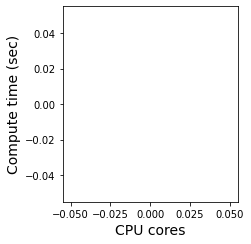

In [13]:
fig, axis = plt.subplots(figsize=(3.5, 3.5))
axis.scatter(cores_vec, times_vec)
axis.set_xlabel('CPU cores', fontsize=14)
axis.set_ylabel('Compute time (sec)', fontsize=14)
fig.tight_layout()

Best practices for parallel computing
 --------------------------------------

 While it may seem tempting to do everything in parallel, it is important to be aware of some of the trade-offs and
 best-practices for parallel computing (multiple CPU cores) when compared to traditional serial computing (single
 CPU core):

 * There is noticeable time overhead involved with setting up each compute worker (CPU core in this case).
   For very simple or small computations, this overhead may outweigh the speed-up gained with using multiple cores.
 * Parallelizing computations that read and write to files at each iteration may be actually be noticeably *slower*
   than serial computation since the cores will compete for rights to read and write to the file(s)
   and these input/output operations are by far the slowest components of the workflow. Instead, it makes sense to
   read large amounts of data from the necessary files once, perform the computation, and then write to the files once
   after all the computation is complete. In fact, this is what we automatically do in the ``Process`` class in pyUSID or pyNSID.
   Please see `another example <./plot_process.html>`_ on how to write a Process class to formalize data processing.

 .. note::
     ``parallel_compute()`` will revert to serial processing when called within the message passing interface (MPI)
     context in a high-performance computing (HPC) cluster. Due to conflicts between MPI, numpy, and joblib, it is
     recommended to use a pure MPI approach for computing instead of the MPI + OpenMP (joblib) paradigm.

#######################################################################################################################
 Cleaning up
 ~~~~~~~~~~~
 Lets not forget to close and delete the temporarily downloaded file:



In [14]:
h5_file.close()
os.remove(h5_path)